In [506]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Preliminaries

### Loading the raw datasets

There are 3 datasets at disposal: train.tsv, test.tsv, test.csv.

I want to later proceed with my own split based on the EDA achieved here, therefore it is a good idea to concatenate the three dataframes into a single one.

In [507]:
columns = [
    "id", 
    "label", 
    "statement", 
    "subjects", 
    "speaker",
    "speaker_job_title",
    "state_info", 
    "party_affiliation",
    "barely_true_counts",
    "false_counts",
    "half_true_counts",
    "mostly_true_counts",
    "pants_on_fire_counts",
    "context"
]

raw_train_df = pd.read_csv(
    "../datasets/raw/train.tsv", 
    sep="\t", 
    header=None,
    names=columns
)
raw_valid_df = pd.read_csv(
    "../datasets/raw/valid.tsv", 
    sep="\t", 
    header=None,
    names=columns
)
raw_test_df = pd.read_csv(
    "../datasets/raw/test.tsv", 
    sep="\t", 
    header=None,
    names=columns
)
raw_df = pd.concat([raw_train_df, raw_valid_df, raw_test_df])
raw_df.reset_index(drop=True, inplace=True)
raw_df.dropna(subset=["label"], inplace=True)

### Preview of the dataset

In [508]:
raw_df.head(20)

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
5,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
7,153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa."
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website
9,9741.json,mostly-true,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video


# Exploration

### Distribution of the labels

There are a total of 6 labels in the raw datasets:
- true
- half-true
- mostly-true
- barely-true
- pants-fire
- false

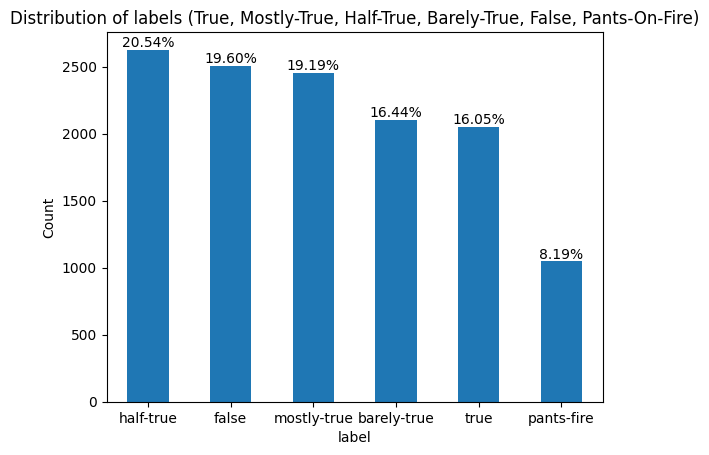

In [509]:
ax = raw_df["label"].value_counts().plot(kind="bar")
ax.set_ylabel("Count")
ax.set_title("Distribution of labels (True, Mostly-True, Half-True, Barely-True, False, Pants-On-Fire)")
ax.tick_params(axis="x", labelrotation=0)
total = len(raw_df)
counts = raw_df["label"].value_counts()
for i, v in enumerate(counts):
    ax.text(i, v, f"{(v/total*100):.2f}%", ha="center", va="bottom")

In [510]:
print(raw_df["label"].value_counts())

label
half-true      2627
false          2507
mostly-true    2454
barely-true    2103
true           2053
pants-fire     1047
Name: count, dtype: int64


Furthermore, we would like to binarize the labels into either True (True, Mostly-True, Half-True) or False (Barely-True, False, Pants-On-Fire)

In [511]:
def binarize_label(label):
    if label in ["true", "mostly-true", "half-true"]:
        return True
    elif label in ["barely-true", "false", "pants-fire"]:
        return False
    else:
        return None

raw_df["label"] = raw_df["label"].apply(binarize_label)

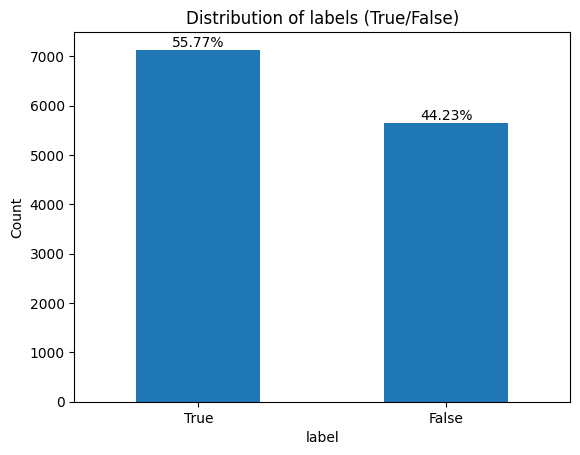

In [512]:
ax = raw_df["label"].value_counts().plot(kind="bar")
ax.set_ylabel("Count")
ax.set_title("Distribution of labels (True/False)")
ax.tick_params(axis="x", labelrotation=0)
total = len(raw_df)
counts = raw_df["label"].value_counts()
for i, v in enumerate(counts):
    ax.text(i, v, f"{(v/total*100):.2f}%", ha="center", va="bottom")

In [513]:
print(raw_df["label"].value_counts())

label
True     7134
False    5657
Name: count, dtype: int64


There is a slight imbalance in the class distribution. Stratified sampling might be relevant when training the models.

### Features importance

#### State Info

##### Errors identification

In [514]:
all_state_info = set(raw_df["state_info"].dropna().unique())
all_state_info

{'Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'Atlanta',
 'California',
 'California ',
 'China',
 'Colorado',
 'Colorado ',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Florida ',
 'Georgia',
 'Georgia ',
 'Georgia  ',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Illinois ',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Massachusetts ',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Hampshire ',
 'New Jersey',
 'New Mexico',
 'New York',
 'New York ',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Oregon ',
 'PA - Pennsylvania',
 'Pennsylvania',
 'Qatar',
 'Rhode Island',
 'Rhode Island ',
 'Rhode island',
 'Russia',
 'South Carolina',
 'South Dakota',
 'Tennesse',
 'Tennessee',
 'Tex',
 'Texas',
 'United Kingdom',
 'Unknown',
 'Utah',
 'Vermont',
 'Virgiia',
 'Virgina',
 'Virginia',
 'Virginia ',
 'Virginia director, Coa

Things to clean:
- Strip the useless spaces
- Canonicalize duplicates (ex: Virgiia and Virginia)

In [515]:
STATE_INFO_CANONICAL_MAPPINGS = {
    "Rhode island": "Rhode Island",
    "Tennesse": "Tennessee",
    "Tex": "Texas",
    "Virgiia": "Virginia",
    "Virgina": "Virginia",
    "Virginia director, Coalition to Stop Gun Violence": "Virginia",
    "ohio": "Ohio",
    "PA - Pennsylvania": "Pennsylvania",
    "Washington DC": "Washington D.C.",
    "Washington, D.C.": "Washington D.C.",
    "District of Columbia": "Washington D.C.",
    "Washington state": "Washington",
    "the United States": "United States",
}

In [516]:
def clean_state_info(x):
    if pd.notnull(x):
        stripped_x = x.strip()
        return STATE_INFO_CANONICAL_MAPPINGS.get(stripped_x, stripped_x)
    else:
        return x

raw_df["state_info"] = raw_df["state_info"].apply(clean_state_info)

In [517]:
all_state_info = set(raw_df["state_info"].dropna().unique())
all_state_info

{'Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'Atlanta',
 'California',
 'China',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Qatar',
 'Rhode Island',
 'Russia',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'United Kingdom',
 'United States',
 'Unknown',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'Washington D.C.',
 'West Virginia',
 'Wisconsin',
 'Wyoming'}

##### State info true/false distribution

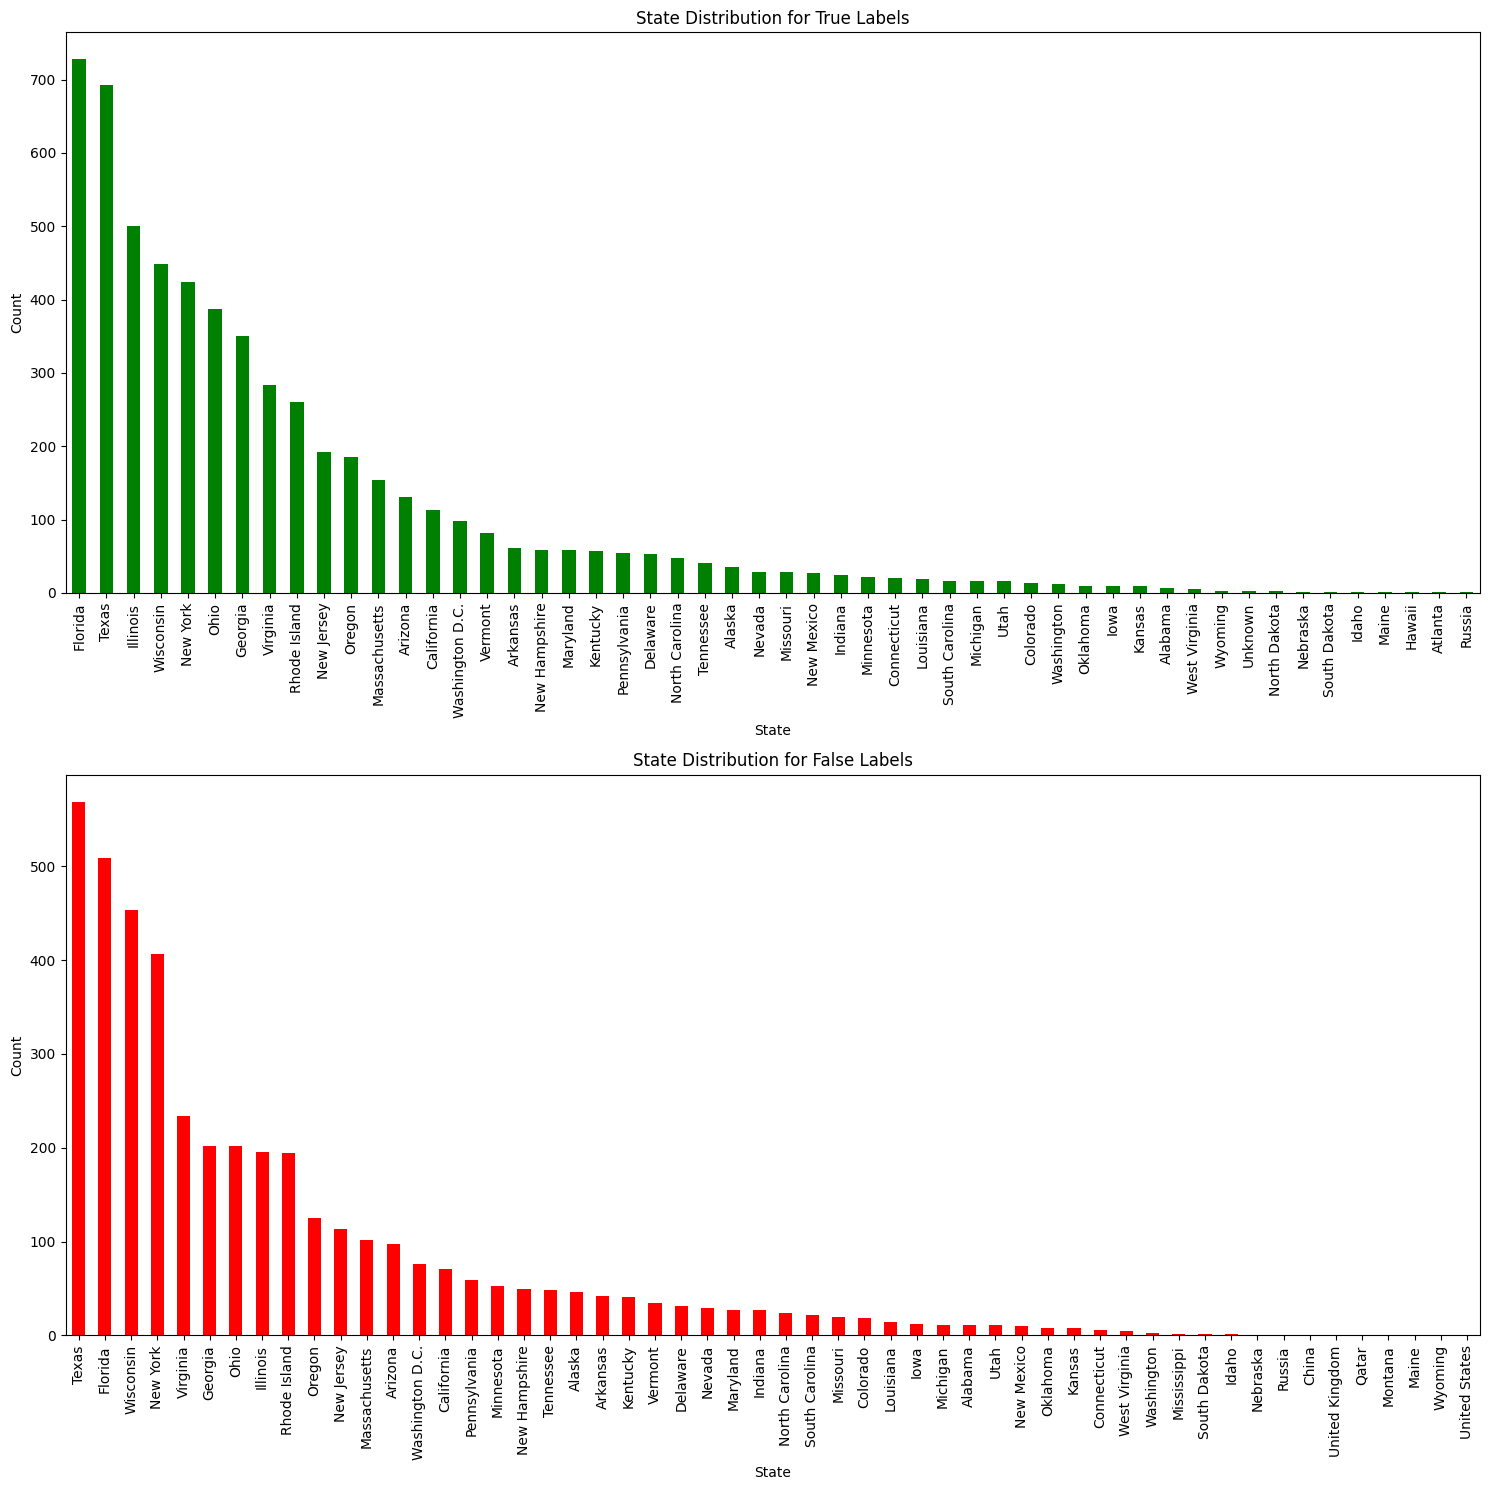

In [518]:
mask = raw_df["label"] == True
true_df = raw_df[mask]

mask = raw_df["label"] == False
false_df = raw_df[mask]

true_state_counts = true_df["state_info"].value_counts()
false_state_counts = false_df["state_info"].value_counts()

fig, axes = plt.subplots(nrows=2, figsize=(15, 15))

true_state_counts.plot(kind="bar", ax=axes[0], color="green")
axes[0].set_title("State Distribution for True Labels")
axes[0].set_xlabel("State")
axes[0].set_ylabel("Count")

false_state_counts.plot(kind="bar", ax=axes[1], color="red")
axes[1].set_title("State Distribution for False Labels")
axes[1].set_xlabel("State")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

#### Speaker Job Title

##### Errors identification

In [519]:
all_speaker_job_info = set(raw_df["speaker_job_title"].dropna().unique())
print(len(all_speaker_job_info))

1354


In [520]:
raw_df["speaker_job_title"].value_counts()[:60]

speaker_job_title
President                                   615
U.S. Senator                                595
Governor                                    487
President-Elect                             343
U.S. senator                                328
Presidential candidate                      314
Former governor                             212
U.S. Representative                         210
Senator                                     193
Milwaukee County Executive                  183
State Senator                               140
U.S. representative                         130
U.S. House of Representatives               118
Attorney                                    110
Governor of New Jersey                      104
Social media posting                        100
Congressman                                  99
State representative                         89
Co-host on CNN's "Crossfire"                 88
State Representative                         86
U.S. Congressman      

There are so many non canonicalized entries in this column.

Things to clean:
- Strip the useless spaces
- Canonicalize duplicates

In [521]:
SPEAKER_JOB_TITLE_CANONICAL_MAPPINGS = {
    # Presidents
    "President": "President",
    "President-Elect": "President-Elect",
    "former president": "Former President",
    
    # U.S. Senators
    "U.S. Senator": "U.S. Senator",
    "U.S. senator": "U.S. Senator",
    "U.S. senator from Ohio": "U.S. Senator",
    
    # Governors
    "Governor": "Governor",
    "governor": "Governor",
    "Former governor": "Former Governor",
    "Governor of New Jersey": "Governor of New Jersey",
    "Governor of Ohio as of Jan. 10, 2011": "Governor of Ohio",
    
    # Presidential Candidate
    "Presidential candidate": "Presidential Candidate",
    
    # U.S. Representatives / House Members
    "U.S. Representative": "U.S. Representative",
    "U.S. representative": "U.S. Representative",
    "U.S. Representative, Florida District 23": "U.S. Representative",
    "U.S. representative, Florida District 22": "U.S. Representative",
    "U.S. House of Representatives": "U.S. Representative",
    "U.S. House member": "U.S. Representative",
    
    # State legislators
    "State Senator": "State Senator",
    "state senator": "State Senator",
    "State representative": "State Representative",
    "state representative": "State Representative",
    
    # Congress persons
    "Congressman": "Congressman",
    "Congresswoman": "Congresswoman",
    
    # Other elected and appointed officials
    "Milwaukee County Executive": "Milwaukee County Executive",
    "Candidate for U.S. Senate and physician": "Candidate for U.S. Senate",
    "State Assemblyman": "State Assemblyman",
    "House Majority Leader": "House Majority Leader",
    "House Minority Leader": "House Minority Leader",
    "Senate minority leader": "Senate Minority Leader",
    "Senate Democratic Leader": "Senate Democratic Leader",
    "Speaker of the House of Representatives": "Speaker of the House of Representatives",
    "Lieutenant governor": "Lieutenant Governor",
    "Lieutenant governor-elect": "Lieutenant Governor-Elect",
    
    # Legal professionals
    "Attorney": "Attorney",
    "Attorney General": "Attorney General",
    "Lawyer": "Lawyer",
    "lawyer": "Lawyer",
    
    # Media, communications, and related
    "Social media posting": "Social Media Posting",
    "Co-host on CNN's \"Crossfire\"": "Co-host on CNN's Crossfire",
    "MSNBC host": "MSNBC Host",
    "Radio host": "Radio Host",
    "Columnist": "Columnist",
    
    # Other professions
    "Businessman": "Businessman",
    "attorney": "Attorney",
    "author": "Author",
    "Actor": "Actor",
    "consultant": "Consultant",
    "Secretary of State": "Secretary of State",
    "Madison school board member": "Madison School Board Member",
    "Ohio treasurer": "Ohio Treasurer",
    "Chairman, Republican National Committee": "Chairman, Republican National Committee",
    "Former mayor of Houston": "Former Mayor of Houston",
    "mayor of Providence ": "Mayor of Providence",
    "Mayor of Milwaukee": "Mayor of Milwaukee",
    "Conservative advocacy group": "Conservative Advocacy Group",
    "political action committee": "Political Action Committee",
}


In [522]:
def clean_speaker_job_title_info(x):
    if pd.notnull(x):
        stripped_x = x.strip()
        return SPEAKER_JOB_TITLE_CANONICAL_MAPPINGS.get(stripped_x, stripped_x)
    else:
        return x

raw_df["speaker_job_title"] = raw_df["speaker_job_title"].apply(clean_speaker_job_title_info)

In [523]:
raw_df["speaker_job_title"].value_counts()[:60]

speaker_job_title
U.S. Senator                               970
President                                  615
U.S. Representative                        593
Governor                                   537
President-Elect                            343
Presidential Candidate                     314
State Representative                       226
Former Governor                            213
State Senator                              193
Senator                                    193
Milwaukee County Executive                 183
Attorney                                   128
Governor of New Jersey                     104
Congressman                                102
Social Media Posting                       100
Co-host on CNN's Crossfire                  88
U.S. Congressman                            82
Speaker of the House of Representatives     72
Candidate for U.S. Senate                   72
Governor of Ohio                            67
Congresswoman                             

##### Job Title Speaker true/false distribution

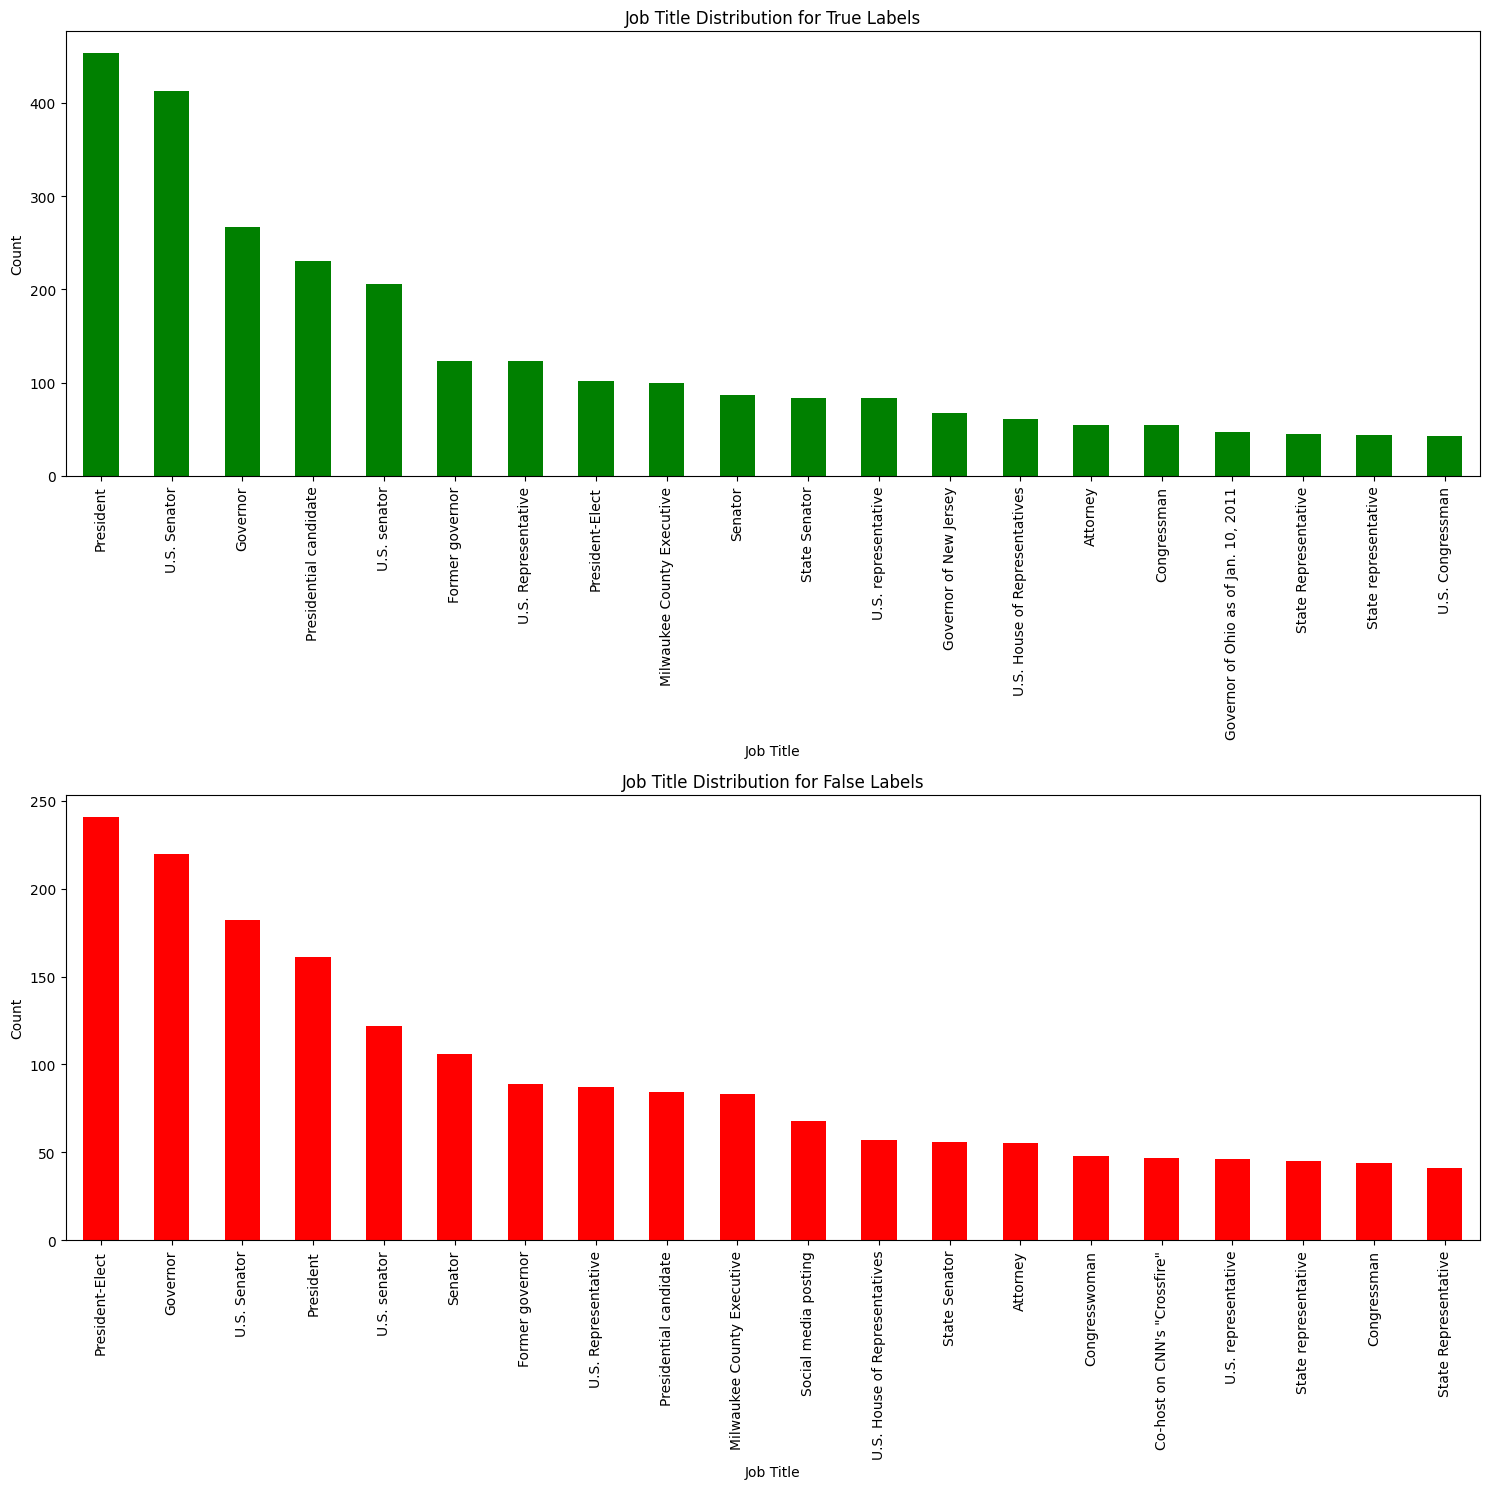

In [524]:
true_speaker_job_counts = true_df["speaker_job_title"].value_counts().head(20)
false_speaker_job_counts = false_df["speaker_job_title"].value_counts().head(20)

fig, axes = plt.subplots(nrows=2, figsize=(15, 15))

true_speaker_job_counts.plot(kind="bar", ax=axes[0], color="green")
axes[0].set_title("Job Title Distribution for True Labels")
axes[0].set_xlabel("Job Title")
axes[0].set_ylabel("Count")

false_speaker_job_counts.plot(kind="bar", ax=axes[1], color="red")
axes[1].set_title("Job Title Distribution for False Labels")
axes[1].set_xlabel("Job Title")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

#### Speaker

##### Speaker true/false distribution

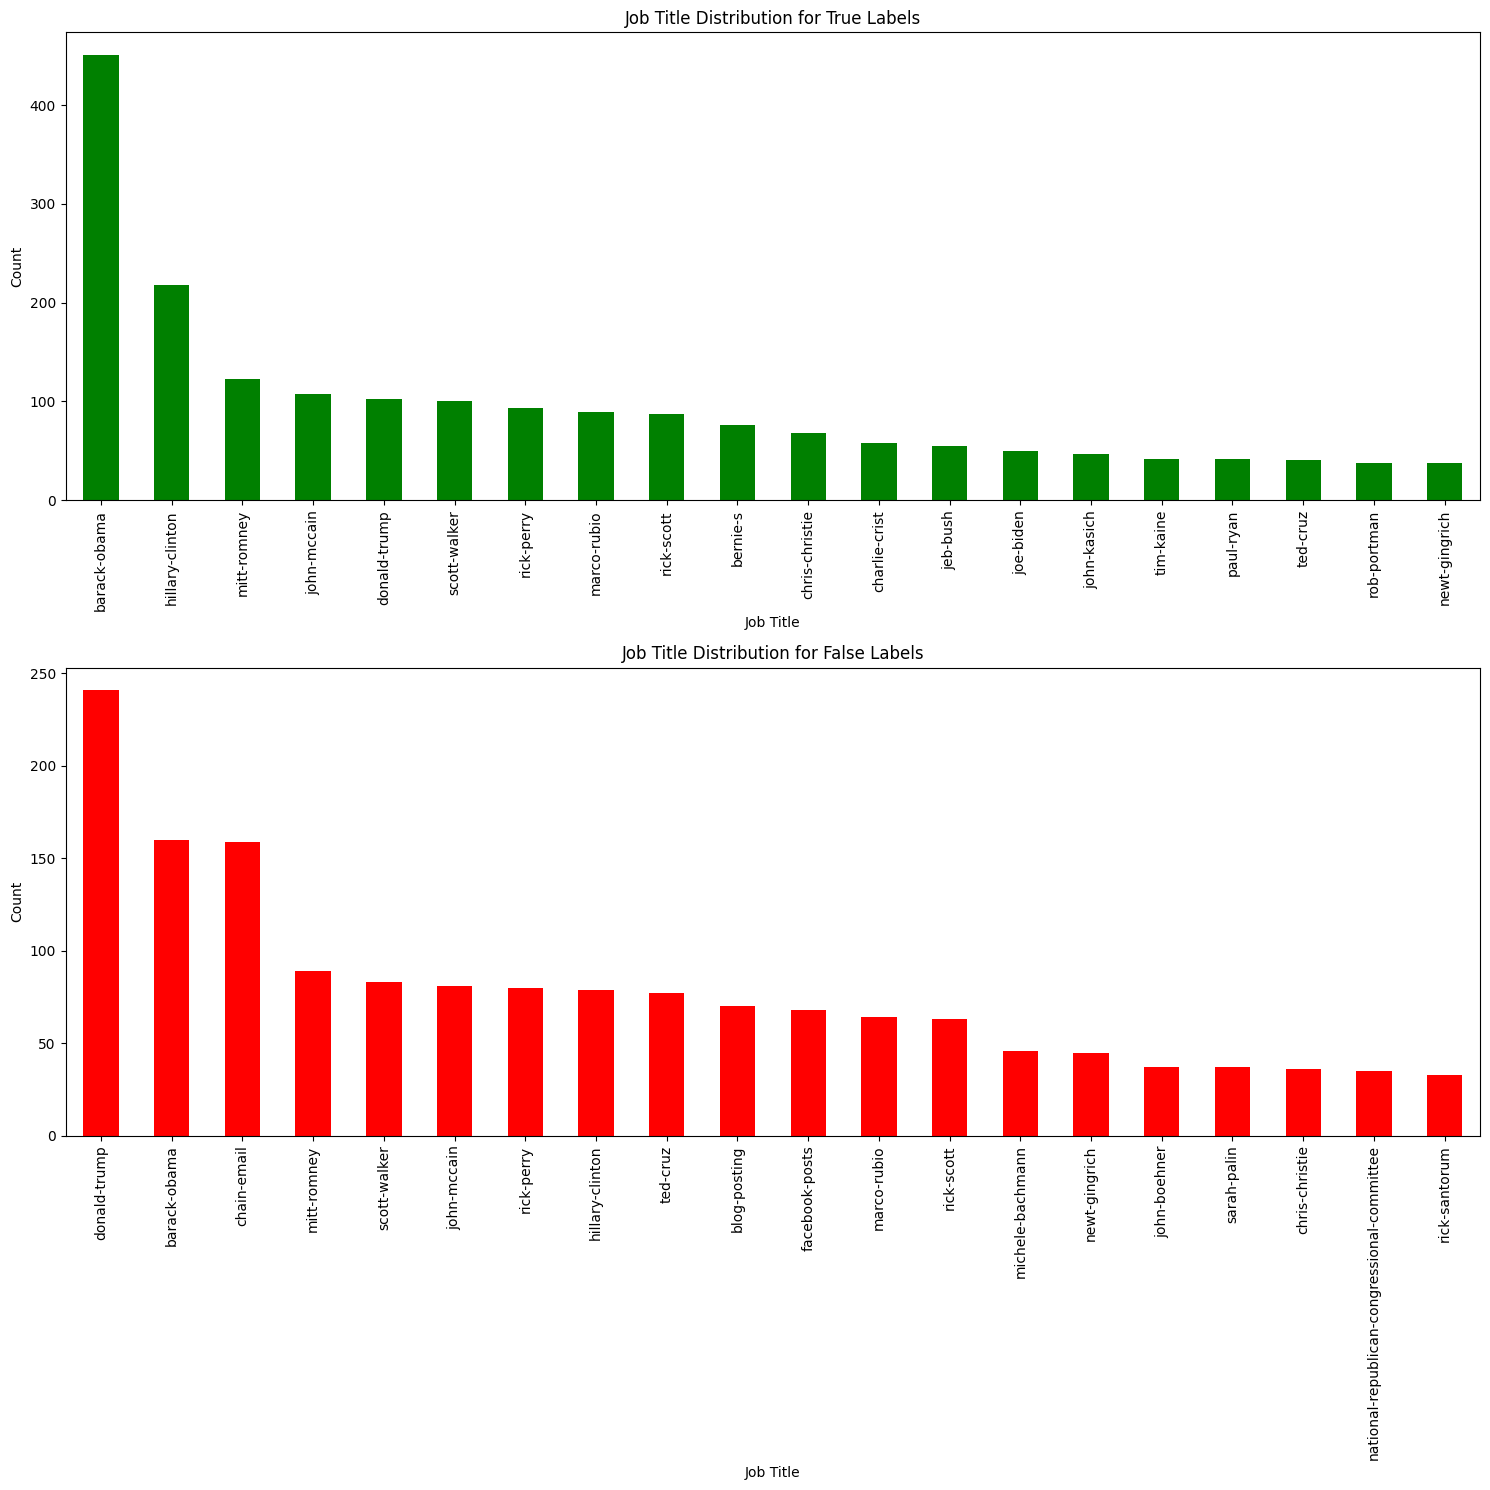

In [525]:
true_speaker_counts = true_df["speaker"].value_counts().head(20)
false_speaker_counts = false_df["speaker"].value_counts().head(20)

fig, axes = plt.subplots(nrows=2, figsize=(15, 15))

true_speaker_counts.plot(kind="bar", ax=axes[0], color="green")
axes[0].set_title("Job Title Distribution for True Labels")
axes[0].set_xlabel("Job Title")
axes[0].set_ylabel("Count")

false_speaker_counts.plot(kind="bar", ax=axes[1], color="red")
axes[1].set_title("Job Title Distribution for False Labels")
axes[1].set_xlabel("Job Title")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

#### Party affiliation

##### Errors identification

In [526]:
all_party_affiliation = set(raw_df["party_affiliation"].dropna().unique())
all_party_affiliation

{'Moderate',
 'activist',
 'business-leader',
 'columnist',
 'constitution-party',
 'county-commissioner',
 'democrat',
 'democratic-farmer-labor',
 'education-official',
 'government-body',
 'green',
 'independent',
 'journalist',
 'labor-leader',
 'liberal-party-canada',
 'libertarian',
 'newsmaker',
 'none',
 'ocean-state-tea-party-action',
 'organization',
 'republican',
 'state-official',
 'talk-show-host',
 'tea-party-member'}

In [527]:
PARTY_AFFILIATION_CANONICAL_MAPPINGS = {
    "Moderate": "moderate",
    "activist": "activist",
    "business-leader": "business-leader",
    "columnist": "columnist",
    "constitution-party": "constitution-party",
    "county-commissioner": "county-commissioner",
    "democrat": "democrat",
    "democratic-farmer-labor": "democratic-farmer-labor",
    "education-official": "education-official",
    "government-body": "government-body",
    "green": "green",
    "independent": "independent",
    "journalist": "journalist",
    "labor-leader": "labor-leader",
    "liberal-party-canada": "liberal-party-canada",
    "libertarian": "libertarian",
    "newsmaker": "newsmaker",
    "none": "none",
    "ocean-state-tea-party-action": "ocean-state-tea-party-action",
    "organization": "organization",
    "republican": "republican",
    "state-official": "state-official",
    "talk-show-host": "talk-show-host",
    "tea-party-member": "tea-party-member"
}

def clean_party_affiliation(x):
    if pd.notnull(x):
        stripped_x = x.strip()
        return PARTY_AFFILIATION_CANONICAL_MAPPINGS.get(stripped_x, stripped_x)
    else:
        return x

raw_df["party_affiliation"] = raw_df["party_affiliation"].apply(clean_party_affiliation)

##### Party affiliation true/false distribution

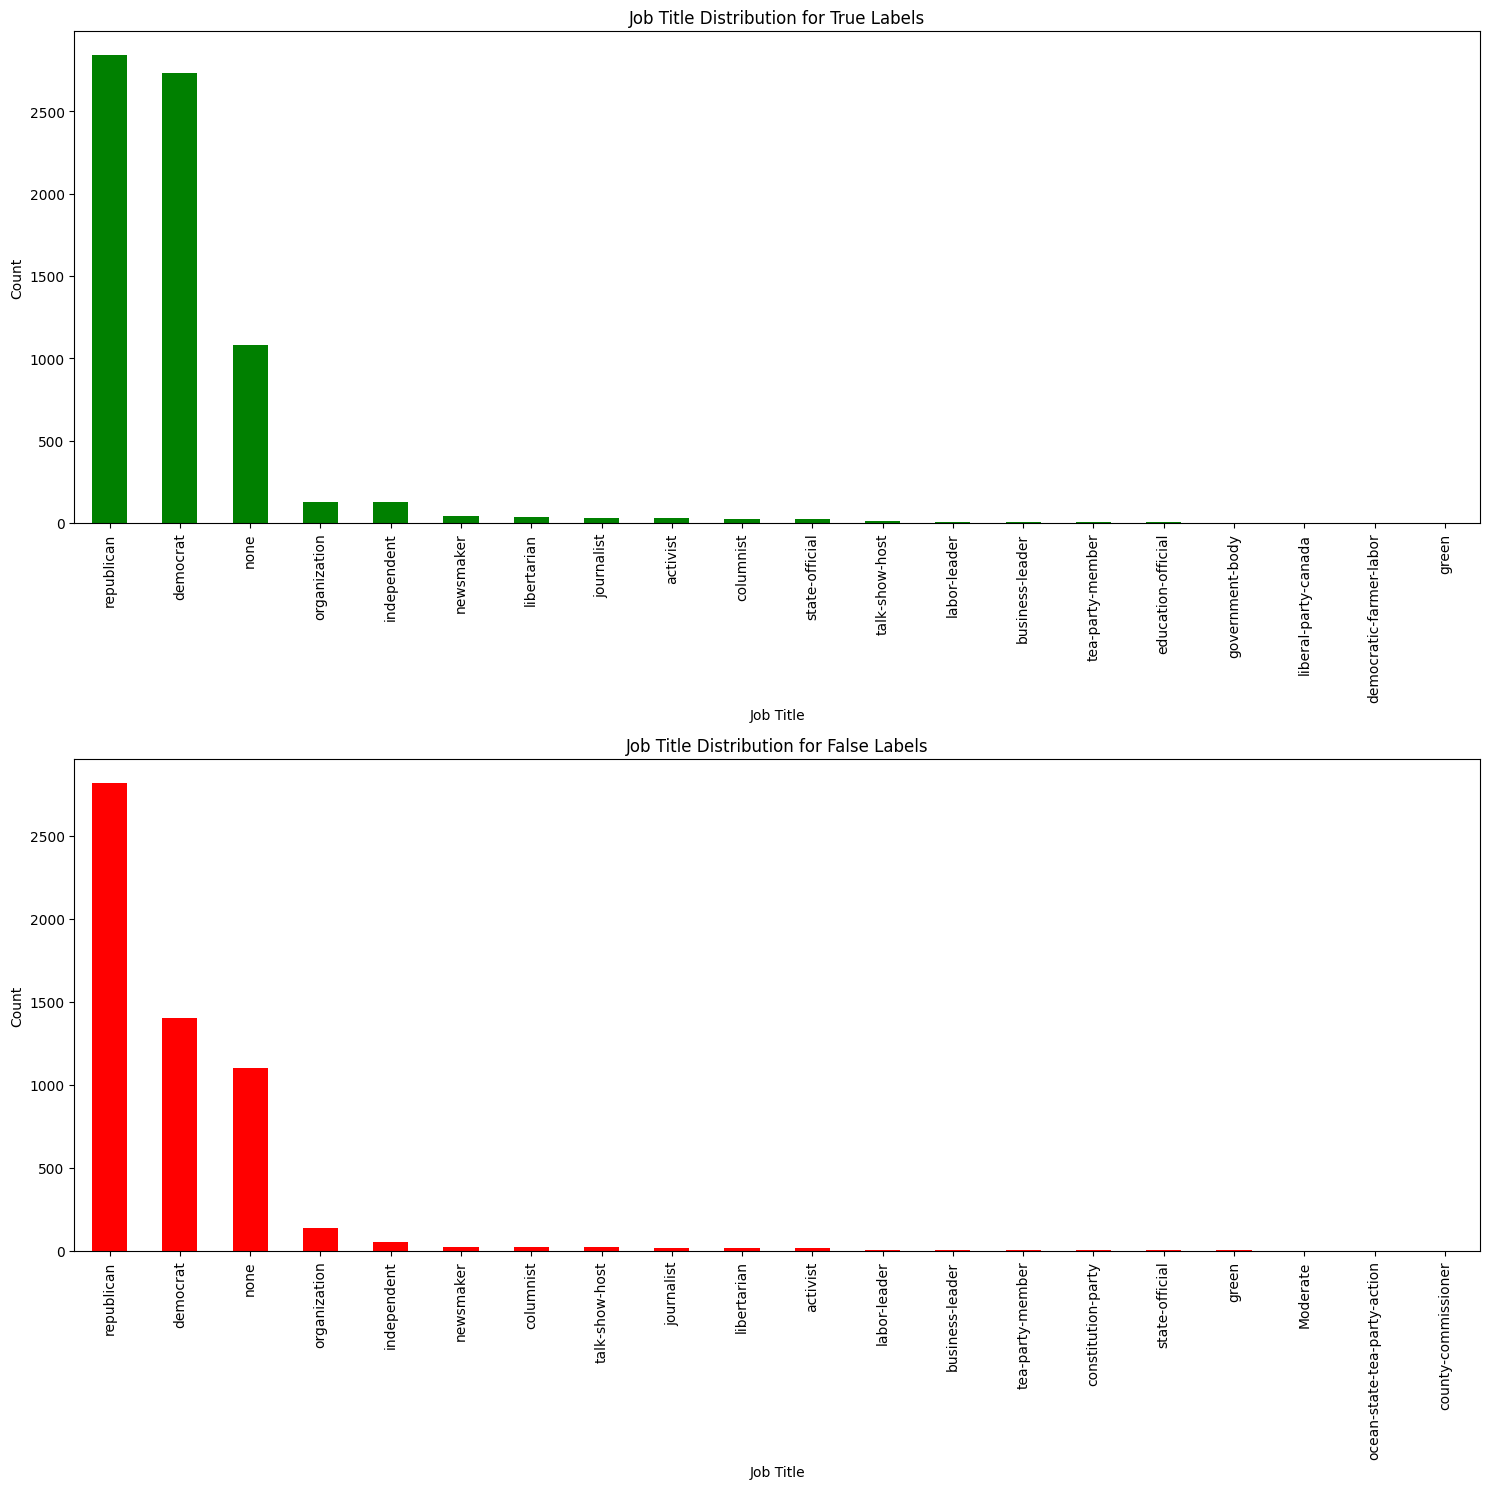

In [528]:
true_party_counts = true_df["party_affiliation"].value_counts().head(20)
false_party_counts = false_df["party_affiliation"].value_counts().head(20)

fig, axes = plt.subplots(nrows=2, figsize=(15, 15))

true_party_counts.plot(kind="bar", ax=axes[0], color="green")
axes[0].set_title("Job Title Distribution for True Labels")
axes[0].set_xlabel("Job Title")
axes[0].set_ylabel("Count")

false_party_counts.plot(kind="bar", ax=axes[1], color="red")
axes[1].set_title("Job Title Distribution for False Labels")
axes[1].set_xlabel("Job Title")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [529]:
mask = raw_df["party_affiliation"] == "republican"
raw_df[mask]["label"].value_counts(normalize=True)

label
True     0.50203
False    0.49797
Name: proportion, dtype: float64

In [530]:
mask = raw_df["party_affiliation"] == "democrat"
raw_df[mask]["label"].value_counts(normalize=True)

label
True     0.660624
False    0.339376
Name: proportion, dtype: float64

### N-grams analysis

In [531]:
def get_top_ngrams(statement, ngram_range, top_n):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words="english")
    X = vectorizer.fit_transform(statement)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = sorted(zip(ngram_features, ngram_counts), key=lambda x: x[1], reverse=True)
    return ngram_freq[:top_n]

#### Unigrams

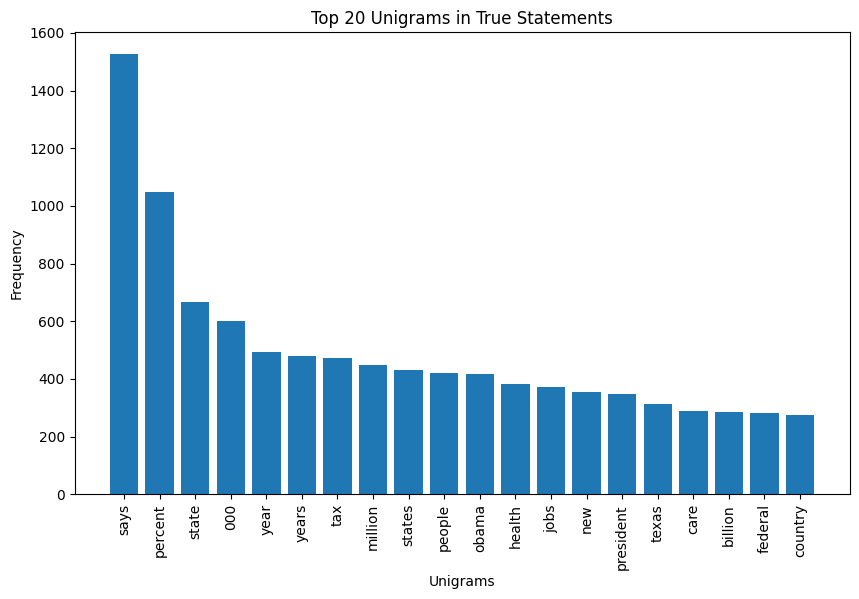

In [532]:
top_true_unigrams = get_top_ngrams(true_df["statement"], ngram_range=(1, 1), top_n=20)
words, freqs = zip(*top_true_unigrams)

plt.figure(figsize=(10,6))
plt.bar(words, freqs)
plt.xlabel("Unigrams")
plt.ylabel("Frequency")
plt.title("Top 20 Unigrams in True Statements")
plt.xticks(rotation=90)
plt.show()

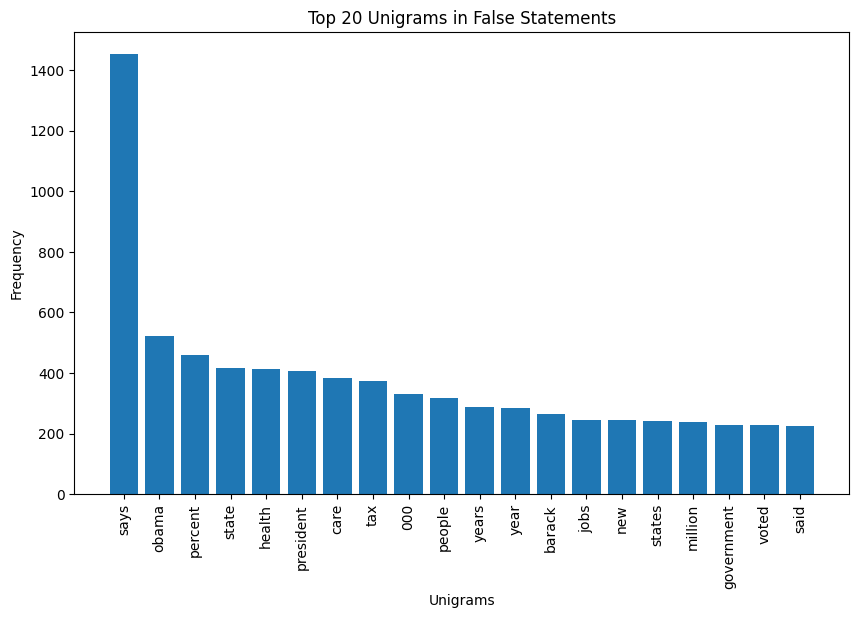

In [533]:
top_false_unigrams = get_top_ngrams(false_df["statement"], ngram_range=(1, 1), top_n=20)
words, freqs = zip(*top_false_unigrams)

plt.figure(figsize=(10,6))
plt.bar(words, freqs)
plt.xlabel("Unigrams")
plt.ylabel("Frequency")
plt.title("Top 20 Unigrams in False Statements")
plt.xticks(rotation=90)
plt.show()

#### Bigrams

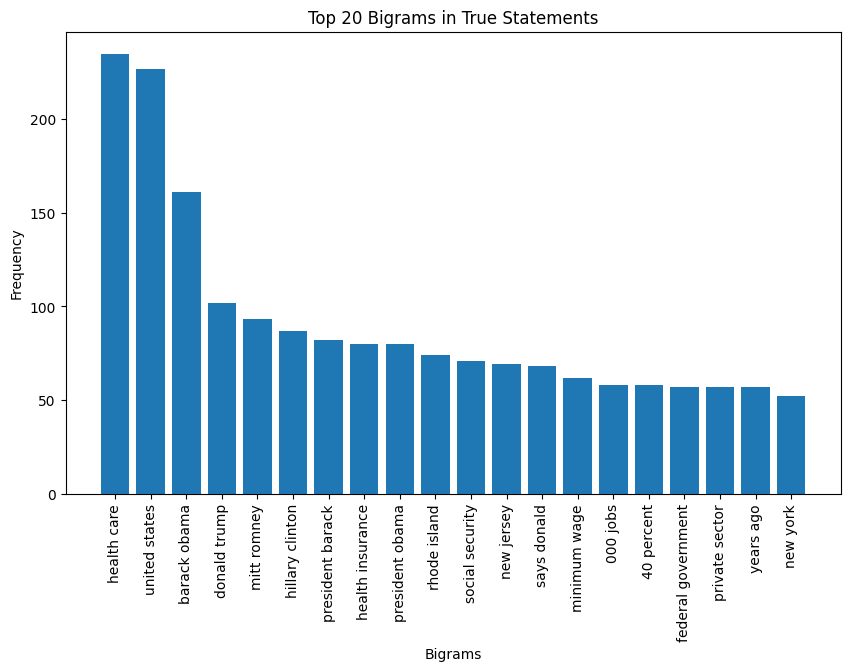

In [534]:
top_true_bigrams = get_top_ngrams(true_df["statement"], ngram_range=(2, 2), top_n=20)
words, freqs = zip(*top_true_bigrams)

plt.figure(figsize=(10,6))
plt.bar(words, freqs)
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.title("Top 20 Bigrams in True Statements")
plt.xticks(rotation=90)
plt.show()

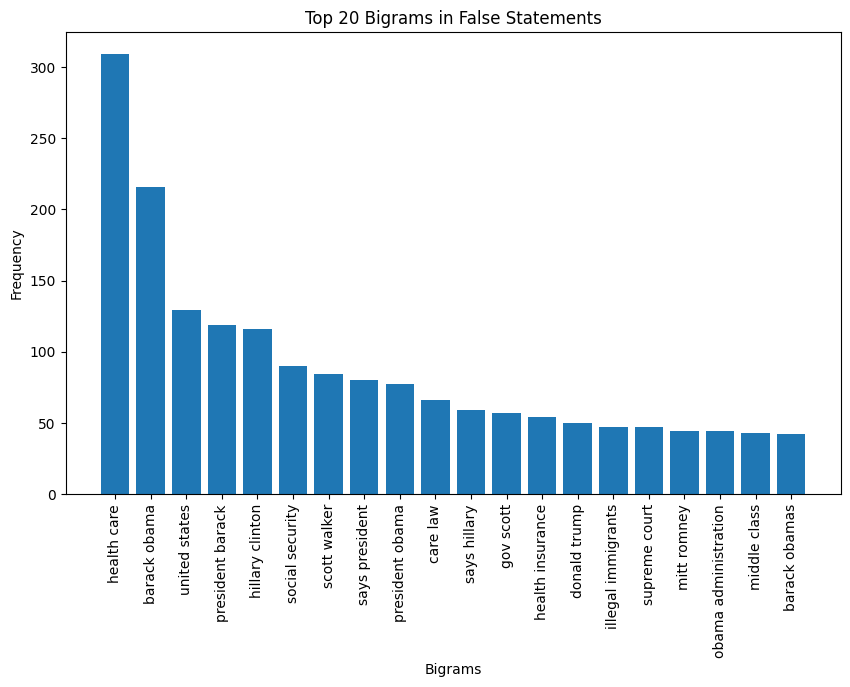

In [535]:
top_false_bigrams = get_top_ngrams(false_df["statement"], ngram_range=(2, 2), top_n=20)
words, freqs = zip(*top_false_bigrams)

plt.figure(figsize=(10,6))
plt.bar(words, freqs)
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.title("Top 20 Bigrams in False Statements")
plt.xticks(rotation=90)
plt.show()

Ngrams as features will have a huge weight on the model performance, as indicated by the prevalence of key words like Obama, healthcare, Trump etc

### Credit distribution

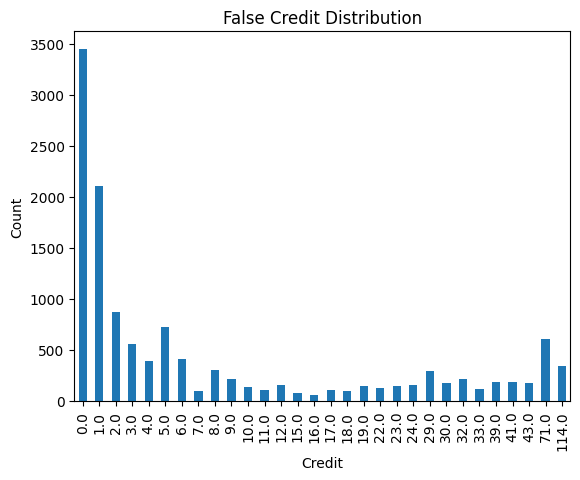

In [536]:
false_counts = raw_df["false_counts"].value_counts().sort_index()
false_counts.plot(kind="bar")
plt.xlabel("Credit")
plt.ylabel("Count")
plt.title("False Credit Distribution")
plt.show()

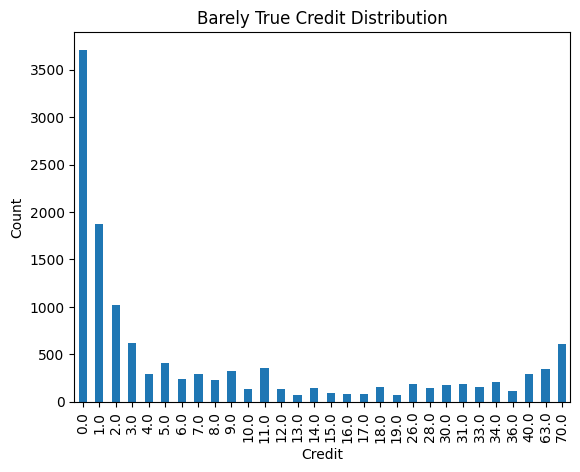

In [537]:
barely_true_counts = raw_df["barely_true_counts"].value_counts().sort_index()
barely_true_counts.plot(kind="bar")
plt.xlabel("Credit")
plt.ylabel("Count")
plt.title("Barely True Credit Distribution")
plt.show()

We may want to use bucketized features in our future model given the concentration of credit scores. For example, the scores of a given speaker (like Obama or Trump as shown above) can be very meaningful features that could impact the model's performance.

### Topic modeling

In [538]:
def print_lda_topics(model: LatentDirichletAllocation, vectorizer: CountVectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        top_weights = topic[top_indices]
        
        print(f"Topic #{topic_idx}:")
        topic_details = ", ".join(f"{word} ({weight:.2f})" for word, weight in zip(top_words, top_weights))
        print(topic_details)
        print()

def run_lda(df, num_topics, n_top_words):
    documents = df["statement"].dropna()
    vectorizer = CountVectorizer(stop_words="english", max_df=0.95, min_df=2)
    doc_term_matrix = vectorizer.fit_transform(documents)
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(doc_term_matrix)
    print_lda_topics(lda_model, vectorizer, n_top_words)

#### True statements

In [539]:
run_lda(true_df, num_topics=5, n_top_words=10)

Topic #0:
says (201.20), state (122.14), romney (106.21), public (99.86), mitt (93.98), government (78.42), obama (70.76), president (65.25), education (63.73), oil (60.72)

Topic #1:
says (431.65), obama (322.30), president (237.77), debt (184.19), year (177.57), barack (166.17), state (161.25), billion (154.30), budget (119.83), people (108.97)

Topic #2:
jobs (373.19), says (254.24), states (232.40), 000 (231.95), new (183.95), million (182.23), tax (177.38), billion (130.03), state (125.89), united (121.75)

Topic #3:
health (381.11), says (363.84), care (289.83), tax (174.18), insurance (149.18), trump (129.19), clinton (126.91), people (126.64), taxes (123.09), donald (118.19)

Topic #4:
percent (961.33), years (290.82), says (276.06), 000 (214.07), year (188.48), state (178.51), rate (174.90), average (170.00), country (152.49), 10 (150.78)



There are some very noticeable topics based on the top words. For example, topic 3 seems to relate to healthcare.

#### False statements

In [540]:
run_lda(false_df, num_topics=5, n_top_words=10)

Topic #0:
says (526.84), clinton (176.20), hillary (141.20), said (118.20), obama (109.72), texas (78.10), scott (72.83), trump (69.20), donald (66.20), president (65.65)

Topic #1:
health (414.17), care (382.20), says (287.81), people (153.98), law (147.24), obama (142.12), insurance (119.11), new (107.29), senate (100.57), medicare (99.43)

Topic #2:
security (126.85), social (103.20), says (82.28), united (69.77), court (68.20), states (67.10), border (50.18), supreme (49.20), people (45.64), voted (44.85)

Topic #3:
percent (328.41), says (282.68), state (280.86), wisconsin (155.46), jobs (147.80), million (118.34), president (108.02), years (100.25), new (99.15), budget (84.50)

Topic #4:
tax (348.00), says (274.38), 000 (190.15), obama (181.82), president (159.38), year (156.09), taxes (130.09), billion (122.25), million (95.70), years (93.46)



# Conclusion

## Cleaning

Overall, there is some cleaning required:
- Canonicalize the state info
- Canonicalize the job titles
- Canonicalize the party affiliations
- Lowercase everything in general

## Possible features

- Manual features: categorical and numerical features + bucketized credit history
- Ngram features